# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [1]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Zygote

using Revise
using BayesianModels

using BasicDataLoaders


# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1278


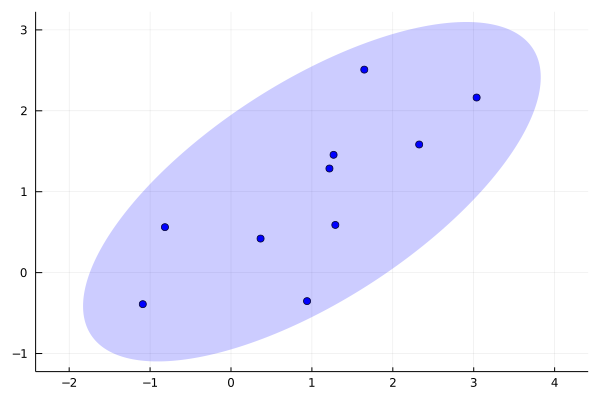

In [2]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[2 1; 1.0  1.1]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

X = draw(10, μₓ, Σₓ)

p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [3]:
function f(D, x)
    m = x[1:D]
    diagΛ = -2*x[D+1:2*D]
    trilΛ = -EFD.inv_vec_tril(x[2*D+1:end])
    Λ = Diagonal(diagΛ) + trilΛ + trilΛ'
    L = cholesky(Λ).L
    vcat(m, diag(L), EFD.vec_tril(L))
end

function f_inv(D, y)
    m = y[1:D]
    diagL = y[D+1:2*D]
    trilL = EFD.inv_vec_tril(y[2*D+1:end])
    L = Diagonal(diagL) + trilL 
    Λ = L*L'
    vcat(m, -.5*diag(Λ), -EFD.vec_tril(Λ))
end


normal_param_map = InvertibleMap(x -> f(2, x), y -> f_inv(2, y))

(::InvertibleMap) (generic function with 1 method)

In [24]:
D = 2
W₀ = Symmetric(Matrix{Float64}(I, D, D))
μ₀ = zeros(D)
Σ₀ = Symmetric(Matrix{Float64}(I, D, D))
pstrength = 1

μ = BayesParam(EFD.Normal(μ₀, pstrength * Σ₀), 
               EFD.Normal(μ₀, pstrength * Σ₀))

#μ = ConstParam(zeros(Float64, 2), stats_fn = θ -> (θ, θ*θ'))
Λ = BayesParam(EFD.Wishart(W₀, D - 1 + pstrength), 
               EFD.Wishart(W₀, D - 1 + pstrength))

#Λ = ConstParam(vec(Float64[1 0; 0 1]), stats_fn = θ -> (reshape(θ, D, D), 0.))

model = BayesianModels.Normal{D}(μ, Λ)

Normal{2} (
  (μ): BayesParam{Float64,ExpFamilyDistributions.Normal{Float64,2}}
  (Λ): BayesParam{Float64,ExpFamilyDistributions.Wishart{Float64,2}}
)


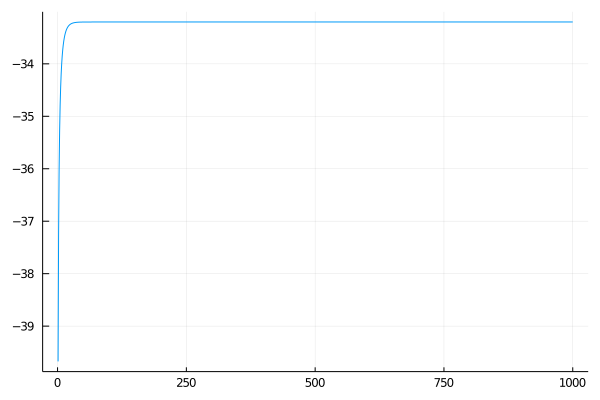

In [25]:
lrate = 0.1
epochs = 1000
batchsize = length(X)

elbos = []#[elbo(model_std, X)]

for epoch in 1:epochs
    dl = DataLoader(shuffle(X), batchsize = batchsize)
    for batch in dl
        gradstep(∇elbo(model, batch, stats_scale = length(dl)), lrate = lrate)
    end
    push!(elbos, elbo(model, X))
end

plot(elbos, legend = false)

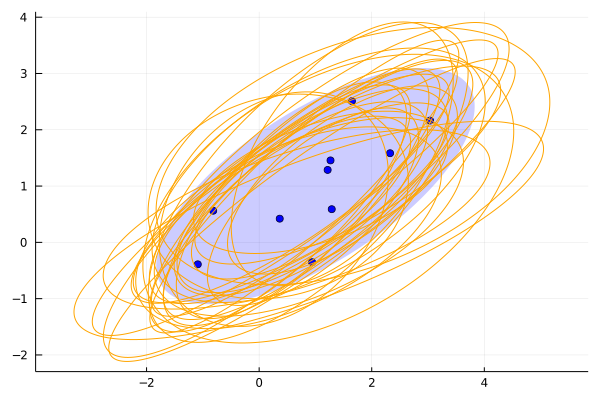

In [26]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

for i in 1:30
    μ = isbayesparam(model.μ) ? EFD.sample(model.μ.posterior)[1] : model.μ.θ 
    Σ = isbayesparam(model.Λ) ? inv(EFD.sample(model.Λ.posterior)[1]) : inv(reshape(model.Λ.θ, D, D))
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

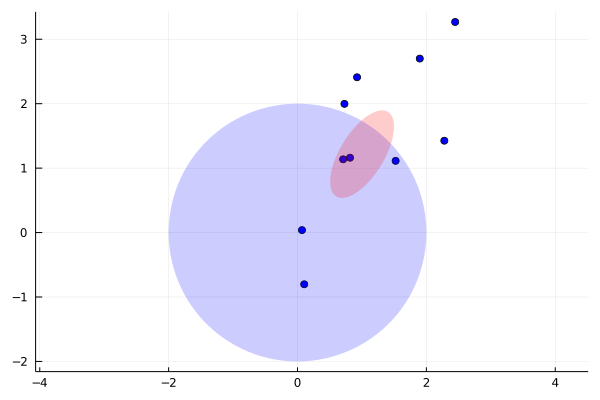

In [16]:
model = model_std
p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(model.μ.prior.μ, model.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model.μ.posterior.μ, model.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p

In [9]:
inv(EFD.mean(model.Λ.posterior))

2×2 Array{Float64,2}:
 0.690028  0.639245
 0.639245  1.34381

In [247]:
∇ = ∇elbo(model, X)[model.Λ]

4-element Array{Float64,1}:
   6.330935775622493e-12
   5.5706550483591855e-12
 -12.939240176818812
   5.044853423896711e-13

In [248]:
η¹ = η⁰ + 0.1 * ∇

4-element Array{Float64,1}:
 -26.121122125980634
 -14.196162122586149
  -0.6469620088407826
  30.999999999999545

In [218]:
EFD.naturalparam(model.Λ.posterior)

4-element Array{Float64,1}:
 -26.12119070499891
 -14.196442801976682
   0.6467003121355828
  30.999203158033367

In [209]:
gradient(() -> elbo(model, X), Params([model.Λ._μ]))[model.Λ._μ]

4-element Array{Float64,1}:
  0.000676551118961477
  0.0008920324345076391
 -1.3116654701096184
  0.00013280699443818378

In [195]:
model.Λ.posterior

ExpFamilyDistributions.Wishart{Float64,2}:
  W = [0.011996452288242266 -0.0004549126663773349; -0.0004549126663773349 0.018182281568926914]
  v = 101.99999999999814

In [189]:
model.Λ.posterior

ExpFamilyDistributions.Wishart{Float64,2}:
  W = [0.011996452282445778 -0.00045491266392272124; -0.00045491266392272124 0.01818228154882423]
  v = 101.9999999294492

In [7]:
D = 5
Q = 2

Wprior = [EFD.Normal{Float64,Q}() for i in 1:D]
Wposterior = [EFD.Normal{Float64,Q}() for i in 1:D]
W = tuple([BayesParam(prior, posterior) for (prior, posterior) in zip(Wprior, Wposterior)]...)
bprior = EFD.Normal{Float64,Q}()
bposterior = EFD.Normal{Float64,Q}()
b = BayesParam(bprior, bposterior)

trans = AffineTransform{D,Q}(W, b)

┌ Error: Failed to revise /home/lucas/GithubRepositories/PPCA/src/bayesparam.jl
│   exception = (LoadError("/home/lucas/GithubRepositories/PPCA/src/bayesparam.jl", 50, "missing comma or ) in argument list"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fa3e1f87263])
└ @ Revise /home/lucas/.julia/packages/Revise/BqeJF/src/Revise.jl:760
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/lucas/GithubRepositories/PPCA/src/bayesparam.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/lucas/.julia/packages/Revise/BqeJF/src/Revise.jl:820


AffineTransform{5,2} (
  (W): [
    (1): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
    (2): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
    (3): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
    (4): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
    (5): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
  ]
  (b): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
)


In [8]:
using ForwardDiff

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/lucas/GithubRepositories/PPCA/src/bayesparam.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/lucas/.julia/packages/Revise/BqeJF/src/Revise.jl:820


In [9]:
μ = EFD.gradlognorm(trans.b.posterior)
x, diagxxᵀ, trilxxᵀ = μ[1:Q], μ[Q+1:2*Q], μ[2*Q+1:end]
trilxxᵀ = EFD.inv_vec_tril(trilxxᵀ)
Σ = diagm(diagxxᵀ) + trilxxᵀ + trilxxᵀ' - x*x'

┌ Error: Failed to revise /home/lucas/GithubRepositories/PPCA/src/bayesparam.jl
│   exception = (LoadError("/home/lucas/GithubRepositories/PPCA/src/bayesparam.jl", 50, "missing comma or ) in argument list"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fa3c0c92189])
└ @ Revise /home/lucas/.julia/packages/Revise/BqeJF/src/Revise.jl:760
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/lucas/GithubRepositories/PPCA/src/bayesparam.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/lucas/.julia/packages/Revise/BqeJF/src/Revise.jl:820


2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [40]:
μ = EFD.gradlognorm(trans.b.posterior)
function s(μ)
    x, diagxxᵀ, trilxxᵀ = μ[1:Q], μ[Q+1:2*Q], μ[2*Q+1:end]
    trilxxᵀ = EFD.inv_vec_tril(trilxxᵀ)
    Σ = diagm(diagxxᵀ) + trilxxᵀ + trilxxᵀ' - x*x'
    xₗ = x + cholesky(Σ).L * ones(eltype(x), length(x))
end

s(μ)

2-element Array{Float64,1}:
 1.0
 1.0

In [41]:
∂b_∂μ = ForwardDiff.jacobian(s, μ) 

2×5 Array{Float64,2}:
 1.0  0.0  0.5  0.0  0.0
 0.0  1.0  0.0  0.5  1.0